# Introduction 

The choice of attributes (features) used to train a machine learning model has a great influence on the performance that can be achieved. If the original data set contains a very large number of attributes, it is possible that there are dependencies between them. As a result, there will be more dimensions in the attribute space than the minimum required to perform any ML task. In addition, in classification or regression tasks, it is possible that there are attributes that are not relevant to infer the value of the target attribute. In the context described above, we can consider applying techniques of *dimensionality reduction* or *feature selection* on the original data set. The purpose of these families of techniques is to reduce the number of attributes to be used when adjusting some ML model.

**Feature selection** is a process in machine learning where **a subset of relevant features (variables, predictors, or attributes) are selected** from a dataset to use in model construction. The goal is to improve model performance, reduce overfitting, shorten training time, and sometimes improve interpretability.

### Is feature selection the same as attribute selection?
Yes — **feature selection** and **attribute selection** are generally used **interchangeably**. Both refer to choosing which input variables should be included in the model.

### Is attribute selection the same as dimensionality reduction?
Not exactly — they're related but **not the same thing**. The difference between dimensionality reduction and attribute selection is that the set of attributes resulting from the application of the latter is a subset of the original set of attributes, while the set of attributes produced by dimensionality reduction does not need to be a subset (for example, example, PCA reduces dimensionality by producing new features which are linear combinations of the original features, and then discarding the less important ones). In this way, we can understand the attribute selection as a particular case of dimensionality reduction. In any case, both DR and AS can be used during the pre-processing phase for later application of a learning algorithm (i.e., fitting some ML model).

> **Feature selection / attribute selection**: Keep only the most important existing variables.

> **Dimensionality reduction**: Create new variables that combine or transform the original ones to reduce dimensionality.

The table below lists the main differences:

| Aspect | Feature Selection | Dimensionality Reduction |
|--------|-------------------|--------------------------|
| What it does | Selects a subset of the original features | Transforms the features into a new space (usually with fewer dimensions) |
| Output | A smaller set of original features | New features (combinations or projections of original ones) |
| Examples | Recursive Feature Elimination (RFE), mutual information, LASSO | Principal Component Analysis (PCA), t-SNE, Autoencoders |
| Interpretability | Easy to interpret (original features retained) | Often harder to interpret (features are transformed) |

Example (2D to 1D):
<center><img src="https://shapeofdata.files.wordpress.com/2013/04/projection.png" alt="Drawing" width="600"/></center>

Example (3D to 2D):
<center><img src="https://i.stack.imgur.com/9ETLr.png" alt="Drawing" width="600"/></center>

# Feature selection methods

## Seleção baseada em variância

No Scikit-Learn, a classe [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) implementa um procedimento simples para a seleção de atributos. Essa estratégia remove todos os atributos cuja variância não atinge algum limite fornecido. Por padrão, esse procedimento remove todos os atributos cuja variância é zero.

A célula a seguir (adaptada deste [exemplo](https://)) ilustra um dataset com três atributos binários. O código descarta os atributos que possuem mais de 80% de zeros (ou de uns). Repare que o primeiro atributo é descartado, visto que há uma probabilidade igual a $5/6$ (maior do que $0.8$) de encontrar um zero.

N.B.: a variância de uma variável aleatória de Bernoulli $X$ cuja probabilidade de sucesso é $p$ é dada por $\operatorname {Var} [X]=p(1-p)$.


In [47]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np

X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]

print(np.asarray(X))

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]
 [0 1 1]]


array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

## Seleção de atributos univariada

A seleção de atributos univariada é útil para seleção de atributos no contexto da tarefa de **classificação**. Essa estratégia seleciona os melhores atributos com base em algum teste estatístico capaz de medir a dependência entre duas variáveis. 

O Scikit-learn expõe rotinas de seleção de atributos como classes que implementam o método de transformação `fit_transform`. Esse método recebe como argumentos a matrix de dados $X$ e a matriz alvo $y$.

Uma dessas rotinas é fornecida pela classe `SelectKBest`. Essa classe pode ser configurada com um dentre um conjunto de testes estatísticos diferentes para selecionar um número específico de atributos. Um dos parâmetros a ser passado é uma função de pontuação, que deve ser aplicável a um par (𝑋, 𝑦). O resultado é uma matriz de pontuações, com uma pontuação para cada atributo de 𝑋. O objeto `SelectKBest` então simplesmente mantém os primeiros $k$ atributos de 𝑋 com as pontuações mais altas.

Se, por exemplo, for passada `chi2` como função de pontuação, `SelectKBest` irá calcular a estatística `chi2` entre cada atributo de 𝑋 e o atributo alvo 𝑦 (presumindo que este último contém os rótulos da classe). Um valor pequeno significará que o atributo é independente de 𝑦. Um valor grande significará que o atributo não está relacionado aleatoriamente a 𝑦 e, portanto, provavelmente fornecerá informações importantes para o estimador. Apenas os 𝑘 atributos de maior pontuação são mantidos.

O exemplo abaixo ilustra o uso de `SelectKBest` com o teste estatístico qui quadrado ($\chi^2$) para selecionar os melhores 4 atributos do conjunto de dados de original.

In [48]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
print(X_new.shape)

(150, 4)
(150, 2)


### Seleção por informação mútua

A [informação mútua](https://en.wikipedia.org/wiki/Mutual_information) (mutual information, MI) entre duas variáveis aleatórias é um valor não negativo, que mede a dependência entre as variáveis. É igual a zero se e somente se duas variáveis aleatórias forem independentes. Quanto maior o valor de MI, maior a dependência estatística entre as variáveis. 

Formalmente,  dadas duas variáveis aleatórias $X$ e $Y$, a MI mede o quão diferente a distribuição conjunta do par ${\displaystyle (X, Y)}$ é do produto de distribuições marginais de ${\displaystyle X}$ e ${\displaystyle Y}$.

Intuitivamente, MI mede o quanto o conhecimento de uma dessas variáveis reduz a incerteza sobre a outra. Por exemplo, se ${\displaystyle X}$ e ${\displaystyle Y}$ forem independentes, saber ${\displaystyle X}$ não fornecerá informações sobre ${\displaystyle Y}$ e vice-versa. Portanto, a informação mútua neste caso é zero. No outro extremo, se ${\displaystyle X}$ é uma função determinística de ${\displaystyle Y}$ e ${\displaystyle Y}$ é uma função determinística de ${\displaystyle X}$, então toda a informação transmitida por ${\displaystyle X }$ é compartilhada com ${\displaystyle Y}$: conhecer ${\displaystyle X}$ determina o valor de ${\displaystyle Y}$ e vice-versa.

A MI não está limitada a variáveis aleatórias de valor real e nem a dependências lineares (como acontece no caso do coeficiente de correlação).

No Scikit-Learn, a função [sklearn.feature_selection.mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) permite estimar a *informação mútua* entre cada atributo previsor e um atributo alvo discreto.


In [49]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif
X = np.array([[0, 0, 0, 1],
              [1, 1, 0, 2],
              [2, 0, 1, 3],
              [2, 0, 1, 3],
              [1, 0, 1, 2]])
y = np.array([0, 1, 2, 2, 1])
mutual_info_classif(X, y, discrete_features=True)

array([1.05492017, 0.22314355, 0.39575279, 1.05492017])

In [50]:
print(X[:,0])

[0 1 2 2 1]


As duas células a seguir ilustram de que forma a computação da MI pode ser implementada. Para entendimento deste código, vale a leitura do link a seguir: https://en.wikipedia.org/wiki/G-test#Relation_to_mutual_information.

In [51]:
import numpy as np
x = np.array([1, 2, 0, 0, 2])
y = np.array([0, 1, 2, 2, 1])
bins = 3
c_xy = np.histogram2d(x, y, bins)[0]
print(c_xy)

[[0. 0. 2.]
 [1. 0. 0.]
 [0. 2. 0.]]


In [52]:
from scipy.stats import chi2_contingency

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood")
    mi = 0.5 * g / c_xy.sum()
    return mi
calc_MI(X[:,0], y, 3)

1.0549201679861442

A classe `SelectPercentile` funciona de forma similar. Essa classe também deve ser configurada com uma função de pontuação. Entretanto, em vez de passar a *quantidade* de atributos que devem permanecer, passamos a *porcentagem* de atributos que devem permanecer (relativamente à quantidade total de atributos em $X$).

No exemplo a seguir, $X$ contém 64 atributos. Após a seleção (repare o uso do parâmetro `percentile` para definir que 10% dos atributos devem ser retidos), o conjunto de dados contém apenas 7 atributos.

In [53]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
X, y = load_digits(return_X_y=True)
print('Antes da seleção:', X.shape)

X_new = SelectPercentile(chi2, percentile=10).fit_transform(X, y)
print('Depois da seleção:', X_new.shape)

Antes da seleção: (1797, 64)
Depois da seleção: (1797, 7)


## Recursive Feature Elimination

A estratégia *Recursive Feature Elimination*, implementada na classe [sklearn.feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) utiliza algum algoritmo de ML que gere modelos preditivos (classificador ou regressor) para selecionar atributos. Essa estratégia é útil em tarefas de classificação ou de regressão, nas quais há um conjunto de atributos previsores e um atributo alvo. A RFE permite selecionar os atributos previsores mais relevantes para predizer o atributo alvo.

O RFE ajusta um modelo preditivo (classificador ou regressor) a diferentes combinações de atributos. Para cada combinação, ele usa a acurácia do modelo ajustado para identificar quais atributos contribuem mais para prever o atributo alvo. Sendo assim, uma pressuposição para aplicar o RFE é que o algoritmo usado para ajuste do modelo a um conjunto de dados $X$ produz um peso (i.e., um indicador numérido de importância) para cada atributo em $X$. 

Inicialmente, o algoritmo de ML é aplicado ao conjunto de dados original $X$. Em seguida, o atributo menos relevante (de acordo com os coeficientes retornados pelo modelo ajustado) é removido de $X$, o que resulta em um novo conjunto de dados $X^\prime$. Um novo modelo é então ajustado sobre novo conjunto de dados $X^\prime$, para gerar uma nova lista de coeficientes de importância. Esse procedimento é realizado recursivamente, até que a quantidade de atributos desejada seja alcançada.

A classe `RFE` possui dois atributos, `support_` e `ranking_`, vetores (do tipo *numpy array*) que podem ser consultados para analisar o resultado da seleção de atributos.

No código de exemplo abaixo, o conjunto de dados Iris é usado para ilustrar o uso de RFE. O conjunto de dados Iris tem 4 atributos previsores, todos medidos em cm:
* comprimento da sépala, 
* largura da sépala, 
* comprimento da pétala, 
* largura da pétala. 

No exemplo  abaixo, o vetor `ranking_` resultante é `[2 1 1 1]`, o que significa que a largura da sépala, o comprimento da pétala e a largura da pétala são todos mais importantes do que o comprimento da sépala.

In [54]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn import datasets

dataset = datasets.load_iris()

svm = LinearSVC()

# create the RFE model for the svm classifier 
# and select attributes
rfe = RFE(svm, n_features_to_select=3)
rfe = rfe.fit(dataset.data, dataset.target)

#
# imprime sumários relativos aos atributos selecionados
#

# um array com valores booleanos para indicar os atributos selecionados
print(rfe.support_)

# um array de inteiros positivos para indicar o ranking de atributos
# (pontuação mais baixa indica um ranking mais alto) 
print(rfe.ranking_)

[False  True  True  True]
[2 1 1 1]


In [55]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

print(selector.support_)


print(selector.ranking_)


[ True  True  True  True  True False False False False False]
[1 1 1 1 1 6 4 3 2 5]


Outra classe do scikit-learn fornecida para seleção de atributos é [`RFECV`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).  Essa é uma sublcasse de RFE.

Uma desvantagem da classe RFE é que a quantidade de atributos a selecionar deve ser fornecida por meio do parâmetro `n_features_to_select`. A classe RFECV ajuda a ajustar (i.e., determinar) o valor desse parâmetro usando validação cruzada. Para cada etapa em que o número de atributos definido em `steps` é eliminado, a RFECV calcula a acurácia em um conjunto de dados de validação. A combinação de atributos que fornece a acurácia máxima nos dados de validação é retornada.

In [56]:
from sklearn.feature_selection import RFECV
regression = SVR(kernel="linear")
selector = RFECV(estimator=regression, cv=10)
selector.fit(X, y)
print("Quantidade ótima de atributos: %d" % selector.n_features_)

Quantidade ótima de atributos: 5


In [57]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
selector.support_ 


selector.ranking_

array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])

### RFECV

The `RFECV` class in **scikit-learn** stands for **Recursive Feature Elimination with Cross-Validation**. It's a feature selection method that recursively removes less important features, using cross-validation to determine the optimal number of features to keep.

#### Steps:
1. **Start with all features** in the dataset.
2. **Fit a model** (e.g., a classifier or regressor) on the training data.
3. **Rank the features** based on importance weights from the estimator (e.g., `coef_` or `feature_importances_`).
4. **Eliminate the least important features** (by default, one at a time).
5. **Use cross-validation** to evaluate the performance of the model at each iteration.
6. **Repeat** the process until the desired number of features is reached.
7. **Select the number of features** that gives the best cross-validation score.

---

#### Main Parameters:

- `estimator`: A model that exposes either `coef_` or `feature_importances_` (e.g., `LogisticRegression`, `RandomForestClassifier`).
- `step`: Number of features to remove at each iteration (can be an integer or float).
- `cv`: Cross-validation splitting strategy (e.g., integer for K-Fold).
- `scoring`: A string or callable to evaluate the model (e.g., `'accuracy'`, `'neg_mean_squared_error'`).
- `min_features_to_select`: Minimum number of features to keep.

#### Attributes:

- `n_features_`: Number of features selected.
- `support_`: Boolean mask of selected features.
- `ranking_`: Feature ranking (1 is best).
- `grid_scores_` (deprecated) or `cv_results_`: CV scores at each step.

In [58]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

X, y = load_breast_cancer(return_X_y=True)
estimator = LogisticRegression(max_iter=10000)

rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features:", rfecv.n_features_)
print("Selected features mask:", rfecv.support_)
print("Feature ranking:", rfecv.ranking_)

Optimal number of features: 20
Selected features mask: [ True  True False False  True  True  True  True  True False  True  True
  True  True False False False False False False  True  True  True False
  True  True  True  True  True  True]
Feature ranking: [ 1  1  3 10  1  1  1  1  1  6  1  1  1  1  8  2  7  5  4  9  1  1  1 11
  1  1  1  1  1  1]


In [59]:
import pandas as pd
data = pd.read_csv('../data/breast-cancer.csv')

In [60]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [61]:
# feature names as a list
col = data.columns       # .columns gives columns names in data 
print(col)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


In [62]:
# y includes our labels and x includes our features
y = data.diagnosis                          # M or B 
list = ['Unnamed: 32','id','diagnosis']
x = data.drop(list,axis = 1 )
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Number of Benign:  357
Number of Malignant :  212


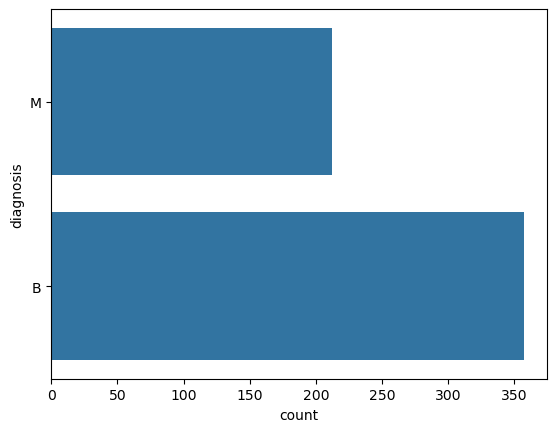

In [63]:
import seaborn as sns
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

## SelectFromModel

A classe [sklearn.feature_selection.SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) pode ser usada com qualquer estimador que tenha campos `coef_` ou `feature_importances_`. Os atributos considerados sem importância são aqueles cujos correspondentes em `coef_` (ou em `feature_importances_`) estiverem abaixo do parâmetro de limite fornecido (`threshold`).

<center>`threshold : string, float, optional default None`</center>

> *The threshold value to use for feature selection. Features whose importance is greater or equal are kept while the others are discarded. If “median” (resp. “mean”), then the threshold value is the median (resp. the mean) of the feature importances. A scaling factor (e.g., “1.25*mean”) may also be used. If None and if the estimator has a parameter penalty set to l1, either explicitly or implicitly (e.g, Lasso), the threshold used is 1e-5. Otherwise, “mean” is used by default.*


In [64]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import numpy as np
import pandas as pd

# Load the dataset
df_iris = sns.load_dataset('iris')
X = df_iris.drop('species', axis=1)  # remove target from feature matrix
y = df_iris['species']  # target attribute

# Train the model
clf = ExtraTreesClassifier(n_estimators=250)
clf = clf.fit(X, y)

# Create a DataFrame with feature importances
feature_importances = pd.DataFrame({
    'Attribute': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importances)
print("\nAverage importance:", clf.feature_importances_.mean())

# Feature selection
model = SelectFromModel(clf, prefit=True)
model.set_output(transform="pandas")  # Ensures output keeps feature names
X_new = model.transform(X)
# model = SelectFromModel(clf, prefit=True)
# X_new = model.transform(X)
print("\nReduced feature set:\n", X_new.columns.to_list())


Feature Importances:
       Attribute  Importance
3   petal_width    0.451211
2  petal_length    0.390083
0  sepal_length    0.100764
1   sepal_width    0.057942

Average importance: 0.24999999999999994

Reduced feature set:
 ['petal_length', 'petal_width']


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


O próximo exemplo é retirado da própria documentação do scikit-learn ([Feature importances with forests of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py))

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


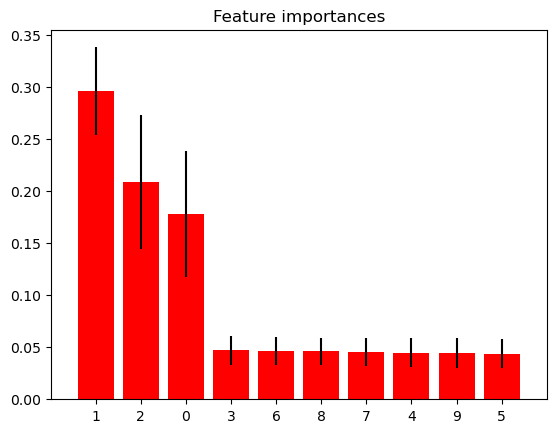

In [65]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## RFE vs SelectFromModel 

As estratégias de seleção de atributos implementadas em RFE e SelectFromModel têm o mesmo propósito, a saber, selecionar um conjunto de atributos relevantes para uma tarefa de predição, mas a metodologia usada em cada técnica varia, conforme descrito a seguir.

* `RFE` remove atributos menos relevantes de forma iterativa: primeiro remove alguns atributos que não são importantes e, em seguida, ajusta novo modelo e remove novamente outros atributos e ajusta novo modelo. Essa estratégia repete essa iteração até atingir um número pré-estabelecido de atributos.

* `SelectFromModel` apenas remove atributos menos importantes com base em um limite fornecido como um parâmetro. Não há iteração envolvida.

# Exercícios

**1** - Considere que a matrix de dados abaixo corresponde a notas de 5 estudantes, nas disciplinas Matemática, Português e Artes. Construa a matriz de covariâncias correspondente à matriz de dados fornecida. Qual o teste que possui maior variância? Qual par de disciplinas está mais correlacionado?
$$
\begin{matrix} 
90 & 60 & 90 \\ 
90 & 90 & 30 \\ 
60 & 60 & 60  \\
60 & 60 & 90 \\ 
30 & 30 & 30 \\ 
\end{matrix}
$$

**2** - Neste exercício, considere a implementação em PCA em numpy e scipy fornecida. O que você espera que os conjuntos de dados projetados sejam para a matriz de dados $X1$ fornecida abaixo? Explique os resultados para $k = 3$ e $k = 1$.

```
X1 = np.array([
        [1,   2, -.05],
        [2,   4, -.05],
        [4,   8, -.05],
        [8,  16, -.05],
    ])
pca(X=X1, k=3)
pca(X=X1, k=1)
```


**3** - Considere o conjunto de dados [MNIST](https://en.wikipedia.org/wiki/MNIST_database), composto de imagens de dígitos de 28x28 pixels. A dimensão original deste conjunto de dados é 784. Utilizando a abordagem de plotar a soma acumulada das variâncias explicadas, determine a dimensão intrínseca desse conjunto de dados. Abaixo, é fornecido o código para carregar o conjunto de dados. 

```
# Load data from https://www.openml.org/d/554
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

print(X_mnist.data.shape)
```

**4** - Considere o conjunto de dados PIMA Indians (fornecido como arquivo em formato CSV). Use as abordagens de seleção de atributos univariada e RFE para determinar quais os atributos mais relevantes relativamente ao atributo alvo.


